In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('~/SCALEX/script')
from metrics import *
plt.rc('font', family='Helvetica')
plt.rcParams['pdf.fonttype'] = 42

In [2]:
def Plot_NMI_ARI(NMI,
                 ARI,
                 ncols=5,
                 nrows=1,
                 palette=None,
                 figsize=(15,2.3),
                 set_yticks=[0,0.25,0.5,0.75,1],
                 set_xticks=[0.5,0.75,1],
                 save='~/SCALEX/figures/benchmark/NMI-ARI_louvain.pdf'
                 ):

    datasets = list(NMI.index)
    methods = list(NMI.columns)

    score = pd.DataFrame({'Dataset':np.repeat(datasets, len(methods)),
                          'Method': methods * len(datasets),
                          'NMI': np.reshape(NMI.values, (1, -1)).squeeze(),
                          'ARI': np.reshape(ARI.values, (1, -1)).squeeze(),})
    
    
    
    plt.rc('font', family='Helvetica')
    plt.rcParams['pdf.fonttype'] = 42

    from matplotlib import gridspec
    figsize=figsize
    fig = plt.figure(figsize=figsize)
    plt.rcParams['savefig.dpi'] = 100
    plt.rcParams['figure.dpi'] = 100
    legend_params_ = {'loc': 'center left',
                      'bbox_to_anchor':(1.05, 0.45),
                      'fontsize': 12,
                      'ncol': 1,
                      'frameon': False,
                      'markerscale': 1.2,
                     }
    axs = gridspec.GridSpec(nrows=nrows, ncols=ncols, height_ratios=[1]*nrows, width_ratios=[1]*ncols, wspace=0.25, hspace=0.25)

    for i, data in enumerate(datasets):
        ax = fig.add_subplot(axs[0, i])
        if i == ncols-1:
            ax = sns.scatterplot(x="NMI", 
                                 y="ARI", 
                                 data=score.loc[score.Dataset == data,:],
                                 hue='Method',
                                 palette=palette,
    #                              legend=False,
                                 marker='+',
                                 s=100)

            plt.legend(**legend_params_)
        else:
            ax = sns.scatterplot(x="NMI", 
                                 y="ARI", 
                                 data=score.loc[score.Dataset == data,:],
                                 hue='Method',
                                 palette=palette, 
                                 legend=False,
                                 marker="+",
                                 s=100)
        ax.set_yticks(set_yticks)
        ax.set_xticks(set_xticks)
        ax.set_title(data, fontsize=15, va='center',pad=10)
        ax.tick_params(axis='y',left=True, right=False, labelright=False, labelleft=True, labelsize=12, length=3, pad=1)

        if i == 0:
            ax.set_ylabel('ARI', rotation=90, fontsize=16, labelpad=10, va='center')
        else:
            ax.set_ylabel('')

        ax.set_xlabel('', fontsize=15, labelpad=10, va='center')
        ax.tick_params(axis='x', bottom=True, top=False, labeltop=False, labelbottom=True, labelsize=12, length=3, pad=3, labelrotation=0)
    fig.text(0.51, -0.1, 'NMI', ha='center',size=16)
    if save:
        plt.savefig(save,format='pdf', bbox_inches='tight')
    else:
        plt.show()

palette = { 'SCALEX': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
            'Raw': (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
            'Seurat_v3': (1.0, 0.4980392156862745, 0.054901960784313725),
            'Harmony':  (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
            'Conos':(0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
            'BBKNN': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
            'Scanorama': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
            'FastMNN':  (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
            'scVI': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
            'online_iNMF':(0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
            'LIGER':(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
            'DESC':(0.8392156862745098, 0.5450980392156863, 0.4980392156862745)}

### Benchmark

In [3]:
datasets =['pancreas', 'heart','liver','NSCLC','PBMC']
methods = ['Raw', 'SCALEX','Seurat_v3','Harmony','Conos','BBKNN','scVI','Scanorama','FastMNN','online_iNMF','LIGER']

In [9]:
datasets = ['pancreas','heart','liver','NSCLC','PBMC']
methods = ['Raw', 'SCALEX', 'Seurat_v3', 'Harmony', 'FastMNN', 'Conos', 'BBKNN', 'Scanorama', 'scVI', 'LIGER', 'online_iNMF','DESC']

NMI_louvain = pd.DataFrame(index = datasets, columns = methods)
ARI_louvain = pd.DataFrame(index = datasets, columns = methods)
NMI_leiden = pd.DataFrame(index = datasets, columns = methods)
ARI_leiden = pd.DataFrame(index = datasets, columns = methods)

for dataset in datasets:
    adata = sc.read_h5ad('~/SCALEX/results/{}/adata.h5ad'.format(dataset))
    if adata.shape[0]>50000:
        idx = np.random.choice(np.arange(adata.shape[0]), 50000, replace=False)
        adata = adata[idx]
        
    for method in methods:
        if method+'_umap' in adata.obsm_keys():
            NMI_louvain.loc[dataset, method] = nmi(adata, 'celltype', method+'_louvain', method="arithmetic", nmi_dir=None)
            ARI_louvain.loc[dataset, method] = ari(adata, 'celltype', method+'_louvain')
            NMI_leiden.loc[dataset, method] = nmi(adata, 'celltype', method+'_leiden', method="arithmetic", nmi_dir=None)
            ARI_leiden.loc[dataset, method] = ari(adata, 'celltype', method+'_leiden')
        else:
            NMI_louvain.loc[dataset, method] = 0
            ARI_louvain.loc[dataset, method] = 0
            NMI_leiden.loc[dataset, method] = 0
            ARI_leiden.loc[dataset, method] = 0

In [20]:
# NMI_louvain.to_csv('~/SCALEX/results/metrics/NMI-ARI/NMI_benchmark_louvain.txt',sep='\t')
# ARI_louvain.to_csv('~/SCALEX/results/metrics/NMI-ARI/ARI_benchmark_louvain.txt',sep='\t')
# NMI_leiden.to_csv('~/SCALEX/results/metrics/NMI-ARI/NMI_benchmark_leiden.txt',sep='\t')
# ARI_leiden.to_csv('~/SCALEX/results/metrics/NMI-ARI/ARI_benchmark_leiden.txt',sep='\t')

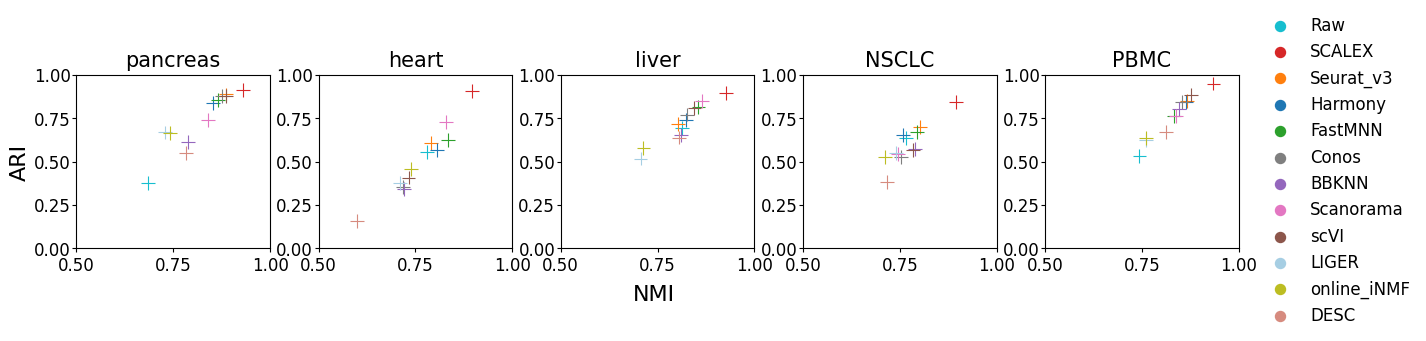

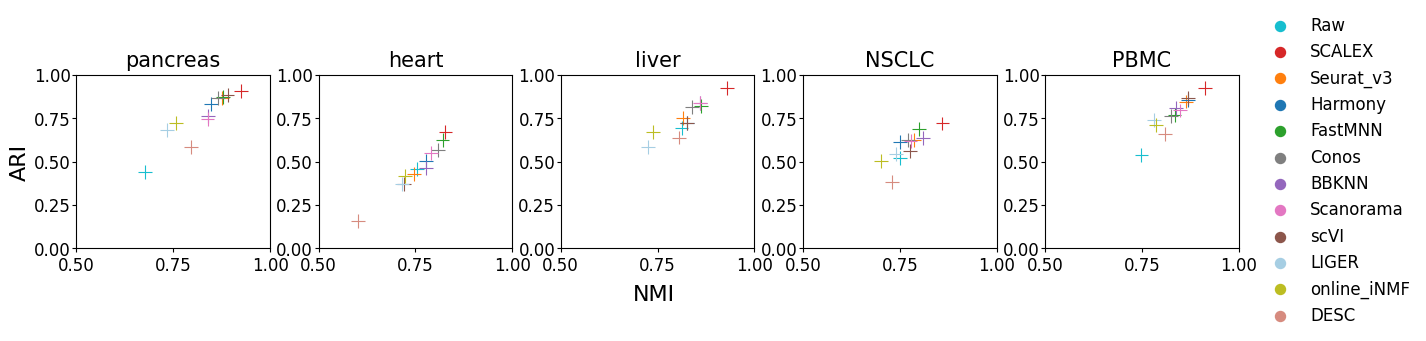

In [25]:
for cluster in ['leiden','louvain']:
    NMI = pd.read_csv('~/SCALEX/results/metrics/NMI-ARI/NMI_benchmark_{}.txt'.format(cluster),sep='\t',index_col=0)
    ARI = pd.read_csv('~/SCALEX/results/metrics/NMI-ARI/ARI_benchmark_{}.txt'.format(cluster),sep='\t',index_col=0)
    Plot_NMI_ARI(NMI,
                 ARI,
                 ncols=5,
                 nrows=1,
                 palette=palette,
                 figsize=(15,2.3),
                 set_yticks=[0, 0.25,0.5,0.75,1],
                 set_xticks=[0.5,0.75,1],
                 save='~/SCALEX/figures/benchmark/NMI-ARI/benchmark_{}.pdf'.format(cluster)
                 )

### Atlas

In [36]:
datasets = ['mouse_atlas', 'human_atlas_adult','COVID-19','human_atlas_fetal']
methods = ['Raw', 'SCALEX','Seurat_v3','Harmony','Conos','BBKNN','scVI','Scanorama','FastMNN','online_iNMF','LIGER']

In [37]:
data = 'atlas'
NMI_louvain = pd.DataFrame(index = datasets, columns = methods)
ARI_louvain = pd.DataFrame(index = datasets, columns = methods)
NMI_leiden = pd.DataFrame(index = datasets, columns = methods)
ARI_leiden = pd.DataFrame(index = datasets, columns = methods)

for dataset in datasets:
    adata = sc.read_h5ad('~/SCALEX/results/{}/adata.h5ad'.format(dataset))
    if adata.shape[0]>50000:
        idx = np.random.choice(np.arange(adata.shape[0]), 50000, replace=False)
        adata = adata[idx]
        
    for method in methods:
        if method+'_umap' in adata.obsm_keys():
            NMI_louvain.loc[dataset, method] = nmi(adata, 'celltype', method+'_louvain', method="arithmetic", nmi_dir=None)
            ARI_louvain.loc[dataset, method] = ari(adata, 'celltype', method+'_louvain')
            NMI_leiden.loc[dataset, method] = nmi(adata, 'celltype', method+'_leiden', method="arithmetic", nmi_dir=None)
            ARI_leiden.loc[dataset, method] = ari(adata, 'celltype', method+'_leiden')
        else:
            NMI_louvain.loc[dataset, method] = 0
            ARI_louvain.loc[dataset, method] = 0
            NMI_leiden.loc[dataset, method] = 0
            ARI_leiden.loc[dataset, method] = 0
NMI_louvain.to_csv('~/SCALEX/results/metrics/NMI-ARI/NMI_{}_louvain.txt'.format(data),sep='\t')
ARI_louvain.to_csv('~/SCALEX/results/metrics/NMI-ARI/ARI_{}_louvain.txt'.format(data),sep='\t')
NMI_leiden.to_csv('~/SCALEX/results/metrics/NMI-ARI/NMI_{}_leiden.txt'.format(data),sep='\t')
ARI_leiden.to_csv('~/SCALEX/results/metrics/NMI-ARI/ARI_{}_leiden.txt'.format(data),sep='\t')

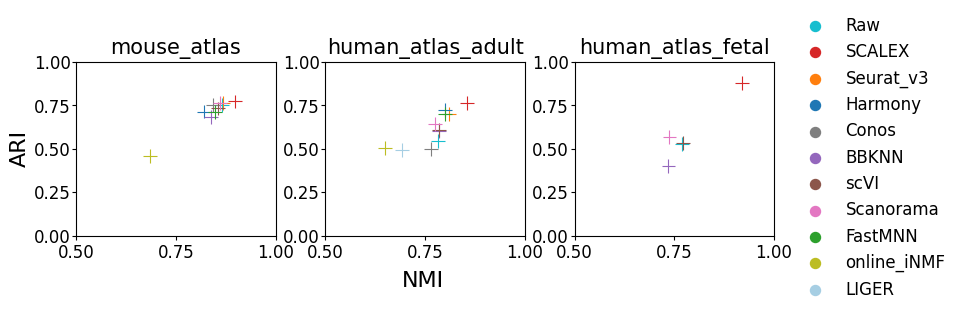

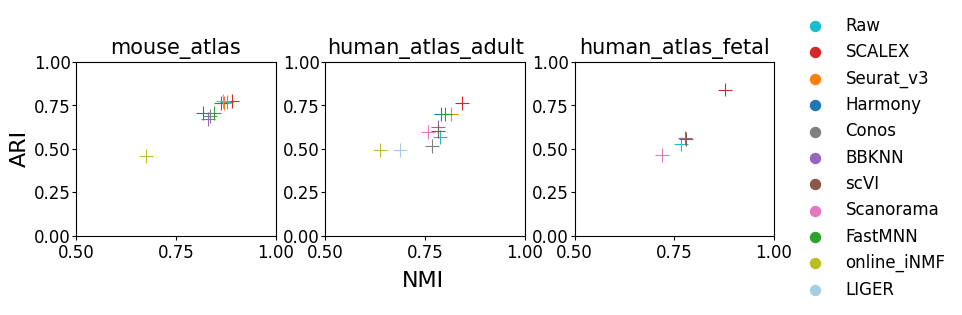

In [38]:
data = 'atlas'
datasets = ['mouse_atlas', 'human_atlas_adult', 'human_atlas_fetal']
for cluster in ['leiden','louvain']:
    NMI = pd.read_csv('~/SCALEX/results/metrics/NMI-ARI/NMI_{}_{}.txt'.format(data, cluster),sep='\t',index_col=0)
    ARI = pd.read_csv('~/SCALEX/results/metrics/NMI-ARI/ARI_{}_{}.txt'.format(data, cluster),sep='\t',index_col=0)
    NMI = NMI.loc[datasets,:]
    ARI = ARI.loc[datasets,:]
    NMI[NMI==0]=None
    ARI[ARI==0]=None
    Plot_NMI_ARI(NMI,
                 ARI,
                 ncols=3,
                 nrows=1,
                 palette=palette,
                 figsize=(9,2.3),
                 set_yticks=[0, 0.25,0.5,0.75,1],
                 set_xticks=[0.5,0.75,1],
                 save='~/SCALEX/figures/benchmark/NMI-ARI/{}_{}.pdf'.format(data, cluster)
                 )

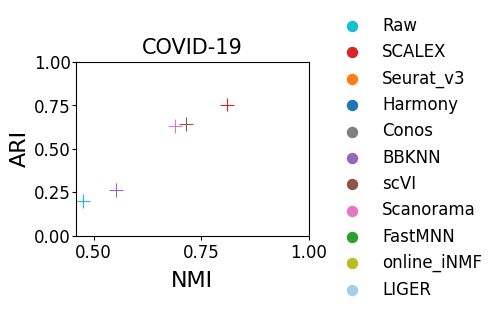

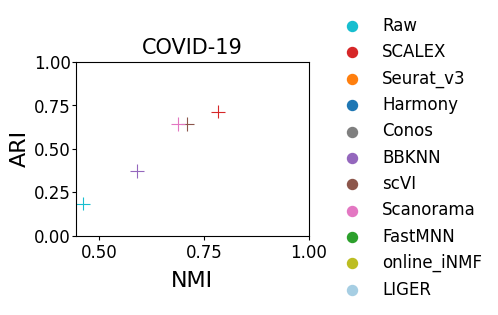

In [ ]:
data = 'atlas'
datasets = ['COVID-19']
for cluster in ['leiden','louvain']:
    NMI = pd.read_csv('~/SCALEX/results/metrics/NMI-ARI/NMI_{}_{}.txt'.format(data, cluster),sep='\t',index_col=0)
    ARI = pd.read_csv('~/SCALEX/results/metrics/NMI-ARI/ARI_{}_{}.txt'.format(data, cluster),sep='\t',index_col=0)
    NMI = NMI.loc[datasets,:]
    ARI = ARI.loc[datasets,:]
    NMI[NMI==0]=None
    ARI[ARI==0]=None
    Plot_NMI_ARI(NMI,
                 ARI,
                 ncols=1,
                 nrows=1,
                 palette=palette,
                 figsize=(3,2.3),
                 set_yticks=[0, 0.25,0.5,0.75,1],
                 set_xticks=[0.5,0.75,1],
                 save='~/SCALEX/figures/benchmark/NMI-ARI/{}_{}.pdf'.format(datasets[0], cluster)
                 )